In [1]:
from CapGenerator import load_data as ld

data = ld.prepare_dataset('train')

Dataset: 6000
Descriptions: train=6000, test=1000
Photos: train=6000, test=1000


In [2]:
train_features, train_descriptions = data[0]

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from CapGenerator import generate_model as gen


# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key Pin descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        return all_desc

    # fit a tokenizer given caption descriptions
    def create_tokenizer(descriptions):
        lines = to_lines(descriptions)
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        return tokenizer

    # calculate the length of the description with the most words
    def max_length(descriptions):
        lines = to_lines(descriptions)
        return max(len(d.split()) for d in lines)

    # create sequences of images, input sequences and output words for an image
    def create_sequences(tokenizer, max_length, desc_list, photo):
        X1, X2, y = list(), list(), list()
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
             s
            # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
                return np.array(X1), np.array(X2), np.array(y)

            # data generator, intended to be used in a call to model.fit_generator()
            def data_generator(descriptions, photos, tokenizer, max_length):
                # loop for ever over images
                while 1:
                    for key, desc_list in descriptions.items():
                        # retrieve the photo feature
                        photo = photos[key][0]
                        print('Photo:')
                        print(photo.shape)
                        in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
                        yield [[in_img, in_seq], out_word]

                        # prepare tokenizer
                        tokenizer = create_tokenizer(train_descriptions)
                        vocab_size = len(tokenizer.word_index) + 1
                        print('Vocabulary Size: %d' % vocab_size)

                        # determine the maximum sequence length
                        max_length = max_length(train_descriptions)
                        print('Description Length: %d' % max_length)

                        # test the data generator
                        generator = gen.data_generator(train_descriptions, train_features, tokenizer, max_length)


SyntaxError: invalid syntax (<ipython-input-3-782ec568ef4b>, line 11)

In [ ]:
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

In [20]:
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers import merge
from keras.layers import GRU
from keras.layers import BatchNormalization

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

EMBEDDING_DIM = 128


def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(4096, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(EMBEDDING_DIM, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)

    # embedding
    inputs2 = Input(shape=(max_length, ))
    emb2 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(emb3)

    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(1000)(merged)
    #lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='plot.png')
    return model

In [11]:
model = define_model(200, 34)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 256)      51200       input_12[0][0]                   
__________________________________________________________________________________________________
dense_4 (D

In [27]:

def image_caption_model(vocab_size=2187, embedding_matrix=None, lang_dim=100,
            max_caplen=53, img_dim=2048, clipnorm=1):
    print('generating vocab_history model v5')
    # text: current word
    lang_input = Input(shape=(1,))
    img_input = Input(shape=(img_dim,))
    seq_input = Input(shape=(max_caplen,))
    vhist_input = Input(shape=(vocab_size,))

    if embedding_matrix is not None:
        x = Embedding(output_dim=lang_dim, input_dim=vocab_size, init='glorot_uniform', input_length=1, weights=[embedding_matrix])(lang_input)
    else:
        x = Embedding(output_dim=lang_dim, input_dim=vocab_size, init='glorot_uniform', input_length=1)(lang_input)

    lang_embed = Reshape((lang_dim,))(x)
    lang_embed = merge([lang_embed, seq_input], mode='concat', concat_axis=-1)
    lang_embed = Dense(lang_dim)(lang_embed)
    lang_embed = Dropout(0.25)(lang_embed)

    merge_layer = merge([img_input, lang_embed, vhist_input], mode='concat', concat_axis=-1)
    merge_layer = Reshape((1, lang_dim+img_dim+vocab_size))(merge_layer)

    gru_1 = GRU(img_dim)(merge_layer)
    gru_1 = Dropout(0.25)(gru_1)
    gru_1 = Dense(img_dim)(gru_1)
    gru_1 = BatchNormalization()(gru_1)
    gru_1 = Activation('softmax')(gru_1)

    attention_1 = merge([img_input, gru_1], mode='mul', concat_axis=-1)
    attention_1 = merge([attention_1, lang_embed, vhist_input], mode='concat', concat_axis=-1)
    attention_1 = Reshape((1, lang_dim + img_dim + vocab_size))(attention_1)
    gru_2 = GRU(1024)(attention_1)
    gru_2 = Dropout(0.25)(gru_2)
    gru_2 = Dense(vocab_size)(gru_2)
    gru_2 = BatchNormalization()(gru_2)
    out = Activation('softmax')(gru_2)
    
    model = Model(input=[img_input, lang_input, seq_input, vhist_input], output=out)
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001, clipnorm=1.))
    plot_model(model, show_shapes=True, to_file='plot.png')
    return model

In [28]:
from keras.layers import Activation
from keras.optimizers import RMSprop

model = image_caption_model()

generating vocab_history model v5


/Users/Divyansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(output_dim=100, input_dim=2187, input_length=1, embeddings_initializer="glorot_uniform")`
  
/Users/Divyansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/Divyansh/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/Divyansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/Divyansh/ana

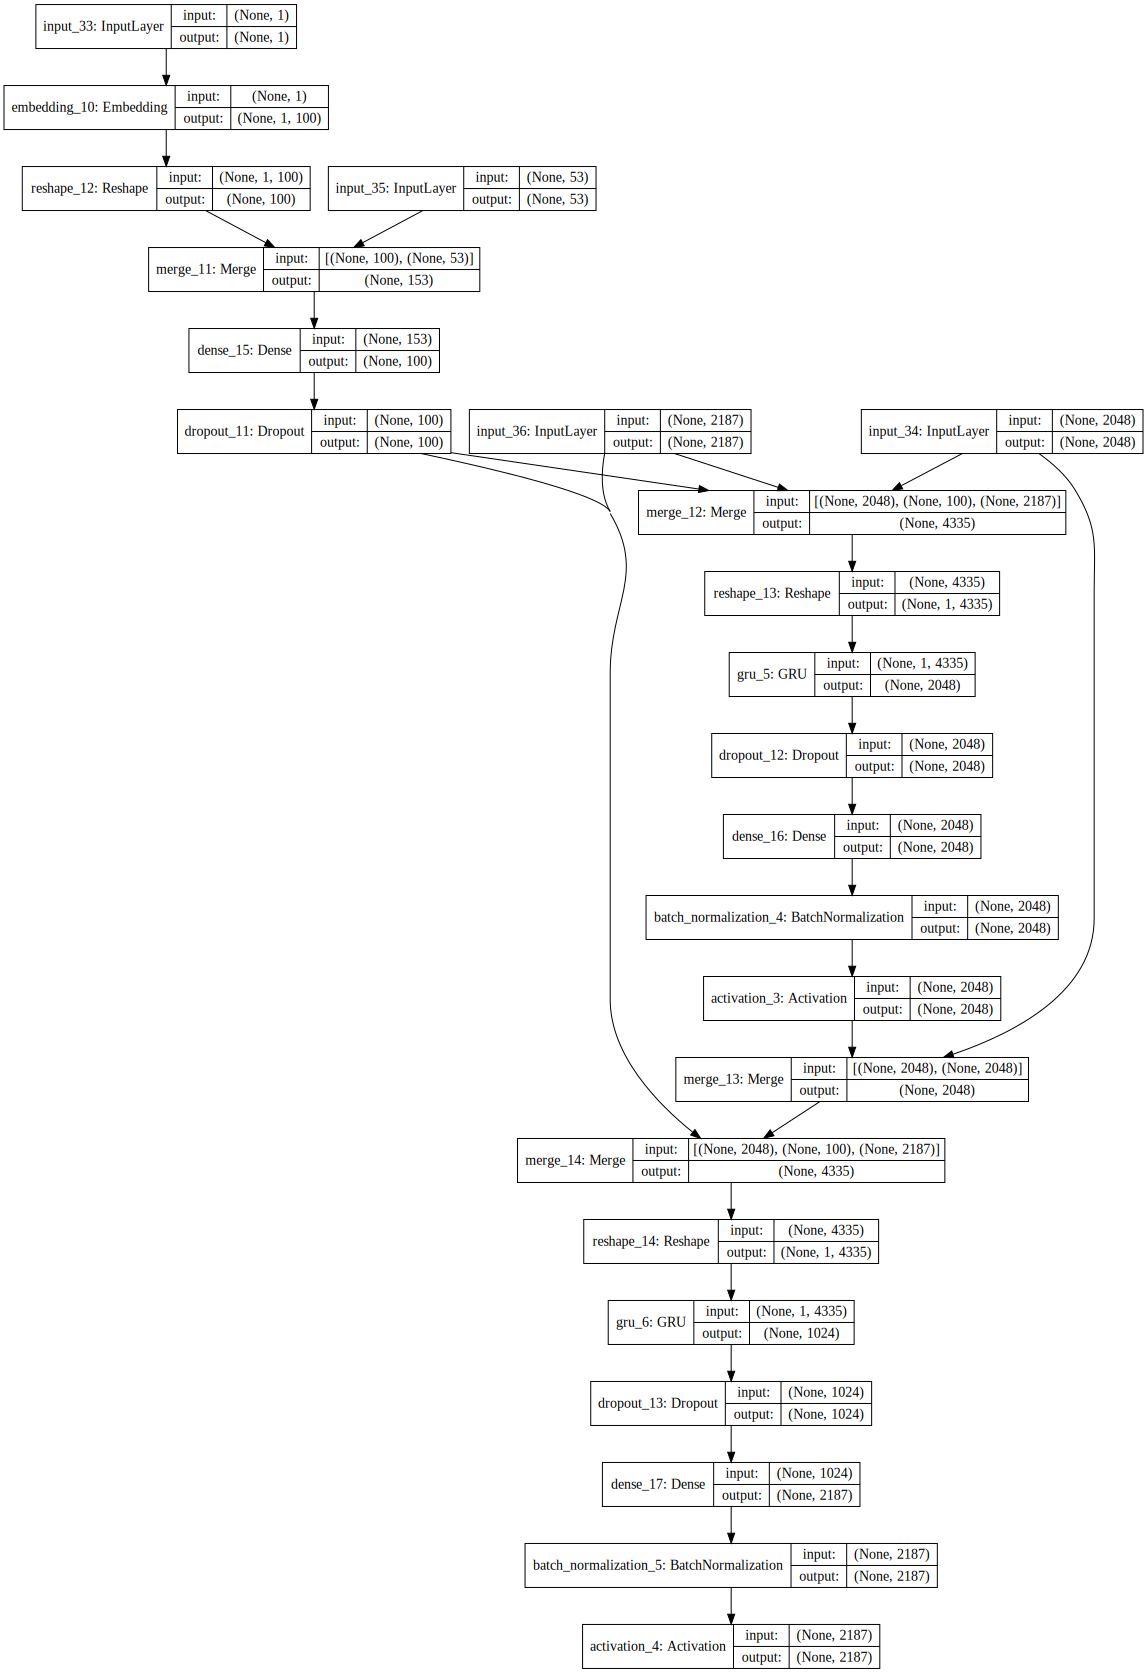

In [26]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [30]:
from keras.models import Model
from keras.layers import Input, Dropout, TimeDistributed, Masking, Dense, Lambda, Permute
from keras.layers import BatchNormalization, Embedding, Activation, Reshape, Multiply
from keras.layers.merge import Add, Concatenate, Average
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2
from keras import backend as K

def NIC(max_token_length, vocabulary_size, rnn='lstm' ,num_image_features=2048,
        hidden_size=512, embedding_size=512, regularizer=1e-8, batch_size= 20):

    # word embedding
    text_input = Input(shape=(max_token_length, vocabulary_size), name='text')#batch_shape=batch_size,
    text_mask = Masking(mask_value=0.0, name='text_mask')(text_input)
    text_to_embedding = TimeDistributed(Dense(units=embedding_size,
                                        kernel_regularizer=l2(regularizer),
                                        name='text_embedding'))(text_mask)

    text_dropout = Dropout(.5, name='text_dropout')(text_to_embedding)

    # image embedding
    image_input = Input(shape=(max_token_length, 14, 14, 512), #batch_shape=batch_size,
                                                        name='image')
    image_input2 = Reshape((max_token_length, 196, 512), name='reshape1')(image_input)
  #  denselastlayer
    image_embedding = TimeDistributed(Dense(units=embedding_size,
                                      kernel_regularizer=l2(regularizer),
                                      name='image_embedding'))(image_input2)
    image_dropout = Dropout(.5, name='image_dropout')(image_embedding)

    # language model
    #recurrent_inputs = [text_dropout, text_dropout]
   # merged_input = Add()(recurrent_inputs)
    if rnn == 'lstm':
        for i in range(max_token_length):
            if i == 0:
              #  first_input = AVE(units=1,
               ##                  name='initial_zero')(image_dropout[:, i, :, :])
                getlistlayer = Lambda(lambda x: [x[:, j, :] for j in range(196)])
                getim0layer = Lambda(lambda x: x[:, 0, :, :])
                temp_layer = getim0layer(image_dropout)
                #order_input = getlistlayer(temp_layer)
                #order_input = [image_dropout[:, i, j, :] for j in range(196)]
                avelayer = Lambda(lambda x:K.mean(x, axis=1))
                first_input = avelayer(temp_layer)
                #first_input = Average()(order_input)
                #first_input = Dense(units=100,
                 #                   kernel_regularizer=l2(regularizer),
                  #                  name='initial_zero_embed')(first_input)
                gettx0layer = Lambda(lambda x: x[:, 0, :])
                first_input2 = gettx0layer(text_dropout)
                recurrent_inputs = [first_input2, first_input]
                merged_input_temp = Add()(recurrent_inputs)
                merged_input = Reshape((1, embedding_size), name='reshape2')(merged_input_temp)
            else:
                getim1layer = Lambda(lambda x: x[:, 1, :, :])
                getim2layer = Lambda(lambda x: x[:, 2, :, :])
                getim3layer = Lambda(lambda x: x[:, 3, :, :])
                getim4layer = Lambda(lambda x: x[:, 4, :, :])
                getim5layer = Lambda(lambda x: x[:, 5, :, :])
                getim6layer = Lambda(lambda x: x[:, 6, :, :])
                getim7layer = Lambda(lambda x: x[:, 7, :, :])
                getim8layer = Lambda(lambda x: x[:, 8, :, :])
                getim9layer = Lambda(lambda x: x[:, 9, :, :])
                getim10layer = Lambda(lambda x: x[:, 10, :, :])
                getim11layer = Lambda(lambda x: x[:, 11, :, :])
                getim12layer = Lambda(lambda x: x[:, 12, :, :])
                getim13layer = Lambda(lambda x: x[:, 13, :, :])
                getim14layer = Lambda(lambda x: x[:, 14, :, :])
                getim15layer = Lambda(lambda x: x[:, 15, :, :])
                getim16layer = Lambda(lambda x: x[:, 16, :, :])
                getim17layer = Lambda(lambda x: x[:, 17, :, :])
                getim18layer = Lambda(lambda x: x[:, 18, :, :])
                getim19layer = Lambda(lambda x: x[:, 19, :, :])
                getim20layer = Lambda(lambda x: x[:, 20, :, :])
                getim21layer = Lambda(lambda x: x[:, 21, :, :])
                getim22layer = Lambda(lambda x: x[:, 22, :, :])
                getim23layer = Lambda(lambda x: x[:, 23, :, :])
                getim24layer = Lambda(lambda x: x[:, 24, :, :])
                getim25layer = Lambda(lambda x: x[:, 25, :, :])
                getim26layer = Lambda(lambda x: x[:, 26, :, :])
                getim27layer = Lambda(lambda x: x[:, 27, :, :])
                getim28layer = Lambda(lambda x: x[:, 28, :, :])
                getim29layer = Lambda(lambda x: x[:, 29, :, :])
                getim30layer = Lambda(lambda x: x[:, 30, :, :])
                getim31layer = Lambda(lambda x: x[:, 31, :, :])
                if i == 1:
                    outputimsplit = getim1layer(image_dropout)
                elif i == 2:
                    outputimsplit = getim2layer(image_dropout)
                elif i==3:
                    outputimsplit = getim3layer(image_dropout)
                elif i == 4:
                    outputimsplit = getim4layer(image_dropout)
                elif i==5:
                    outputimsplit = getim5layer(image_dropout)
                elif i == 6:
                    outputimsplit = getim6layer(image_dropout)
                elif i==7:
                    outputimsplit = getim7layer(image_dropout)
                elif i == 8:
                    outputimsplit = getim8layer(image_dropout)
                elif i==9:
                    outputimsplit = getim9layer(image_dropout)
                elif i == 10:
                    outputimsplit = getim10layer(image_dropout)
                elif i==11:
                    outputimsplit = getim11layer(image_dropout)
                elif i == 12:
                    outputimsplit = getim12layer(image_dropout)
                elif i==13:
                    outputimsplit = getim13layer(image_dropout)
                elif i == 14:
                    outputimsplit = getim14layer(image_dropout)
                elif i==15:
                    outputimsplit = getim15layer(image_dropout)
                elif i == 16:
                    outputimsplit = getim16layer(image_dropout)
                elif i==17:
                    outputimsplit = getim17layer(image_dropout)
                elif i == 18:
                    outputimsplit = getim18layer(image_dropout)
                elif i==19:
                    outputimsplit = getim19layer(image_dropout)
                elif i == 20:
                    outputimsplit = getim20layer(image_dropout)
                elif i==21:
                    outputimsplit = getim21layer(image_dropout)
                elif i == 22:
                    outputimsplit = getim22layer(image_dropout)
                elif i==23:
                    outputimsplit = getim23layer(image_dropout)
                elif i == 24:
                    outputimsplit = getim24layer(image_dropout)
                elif i==25:
                    outputimsplit = getim25layer(image_dropout)
                elif i == 26:
                    outputimsplit = getim26layer(image_dropout)
                elif i==27:
                    outputimsplit = getim27layer(image_dropout)
                elif i == 28:
                    outputimsplit = getim28layer(image_dropout)
                elif i==29:
                    outputimsplit = getim29layer(image_dropout)
                elif i == 30:
                    outputimsplit = getim30layer(image_dropout)
                else:
                    outputimsplit = getim31layer(image_dropout)
                per_out = Permute((2, 1))(outputimsplit)
                per_out1 = Dense(units=1,
                                   kernel_regularizer=l2(regularizer))(per_out)
                dim_change = Dense(units=128,
                                   kernel_regularizer=l2(regularizer))(lstm_out)
                dim_change2 = Permute((2, 1))(dim_change)
                #per_out2 = Reshape((196, 1))(dim_change)
                attendout3 = Multiply()([per_out1, dim_change2])
                pre_merge = Reshape((1, embedding_size))(attendout3)
                gettx1layer = Lambda(lambda x: x[:, 1, :])
                gettx2layer = Lambda(lambda x: x[:, 2, :])
                gettx3layer = Lambda(lambda x: x[:, 3, :])
                gettx4layer = Lambda(lambda x: x[:, 4, :])
                gettx5layer = Lambda(lambda x: x[:, 5, :])
                gettx6layer = Lambda(lambda x: x[:, 6, :])
                gettx7layer = Lambda(lambda x: x[:, 7, :])
                gettx8layer = Lambda(lambda x: x[:, 8, :])
                gettx9layer = Lambda(lambda x: x[:, 9, :])
                gettx10layer = Lambda(lambda x: x[:, 10, :])
                gettx11layer = Lambda(lambda x: x[:, 11, :])
                gettx12layer = Lambda(lambda x: x[:, 12, :])
                gettx13layer = Lambda(lambda x: x[:, 13, :])
                gettx14layer = Lambda(lambda x: x[:, 14, :])
                gettx15layer = Lambda(lambda x: x[:, 15, :])
                gettx16layer = Lambda(lambda x: x[:, 16, :])
                gettx17layer = Lambda(lambda x: x[:, 17, :])
                gettx18layer = Lambda(lambda x: x[:, 18, :])
                gettx19layer = Lambda(lambda x: x[:, 19, :])
                gettx20layer = Lambda(lambda x: x[:, 20, :])
                gettx21layer = Lambda(lambda x: x[:, 21, :])
                gettx22layer = Lambda(lambda x: x[:, 22, :])
                gettx23layer = Lambda(lambda x: x[:, 23, :])
                gettx24layer = Lambda(lambda x: x[:, 24, :])
                gettx25layer = Lambda(lambda x: x[:, 25, :])
                gettx26layer = Lambda(lambda x: x[:, 26, :])
                gettx27layer = Lambda(lambda x: x[:, 27, :])
                gettx28layer = Lambda(lambda x: x[:, 28, :])
                gettx29layer = Lambda(lambda x: x[:, 29, :])
                gettx30layer = Lambda(lambda x: x[:, 30, :])
                gettx31layer = Lambda(lambda x: x[:, 31, :])
                if i == 1:
                    outputtxsplit = gettx1layer(image_dropout)
                elif i == 2:
                    outputtxsplit = gettx2layer(image_dropout)
                elif i==3:
                    outputtxsplit = gettx3layer(image_dropout)
                elif i == 4:
                    outputtxsplit = gettx4layer(image_dropout)
                elif i==5:
                    outputtxsplit = gettx5layer(image_dropout)
                elif i == 6:
                    outputtxsplit = gettx6layer(image_dropout)
                elif i==7:
                    outputtxsplit = gettx7layer(image_dropout)
                elif i == 8:
                    outputtxsplit = gettx8layer(image_dropout)
                elif i==9:
                    outputtxsplit = gettx9layer(image_dropout)
                elif i == 10:
                    outputtxsplit = gettx10layer(image_dropout)
                elif i==11:
                    outputtxsplit = gettx11layer(image_dropout)
                elif i == 12:
                    outputtxsplit = gettx12layer(image_dropout)
                elif i==13:
                    outputtxsplit = gettx13layer(image_dropout)
                elif i == 14:
                    outputtxsplit = gettx14layer(image_dropout)
                elif i==15:
                    outputtxsplit = gettx15layer(image_dropout)
                elif i == 16:
                    outputtxsplit = gettx16layer(image_dropout)
                elif i==17:
                    outputtxsplit = gettx17layer(image_dropout)
                elif i == 18:
                    outputtxsplit = gettx18layer(image_dropout)
                elif i==19:
                    outputtxsplit = gettx19layer(image_dropout)
                elif i == 20:
                    outputtxsplit = gettx20layer(image_dropout)
                elif i==21:
                    outputtxsplit = gettx21layer(image_dropout)
                elif i == 22:
                    outputtxsplit = gettx22layer(image_dropout)
                elif i==23:
                    outputtxsplit = gettx23layer(image_dropout)
                elif i == 24:
                    outputtxsplit = gettx24layer(image_dropout)
                elif i==25:
                    outputtxsplit = gettx25layer(image_dropout)
                elif i == 26:
                    outputtxsplit = gettx26layer(image_dropout)
                elif i==27:
                    outputtxsplit = gettx27layer(image_dropout)
                elif i == 28:
                    outputtxsplit = gettx28layer(image_dropout)
                elif i==29:
                    outputtxsplit = gettx29layer(image_dropout)
                elif i == 30:
                    outputtxsplit = gettx30layer(image_dropout)
                else:
                    outputtxsplit = gettx31layer(image_dropout)
                shape_im = Permute((2, 1))(outputtxsplit)
                dim_change_im = Dense(units=1,
                                    kernel_regularizer=l2(regularizer))(shape_im)
                pre_merge_txt = Permute((2, 1))(dim_change_im)
                #pre_merge_txt = Reshape((1, embedding_size))(outputtxsplit)
                recurrent_inputs = [pre_merge_txt, pre_merge]
                merged_input = Add()(recurrent_inputs)
                #merged_input = Reshape((1, embedding_size), name='reshape3')(merged_input_temp)
            lstm_out = LSTM(units=hidden_size,#[:, i, :]
                            recurrent_regularizer=l2(regularizer),
                            kernel_regularizer=l2(regularizer),
                            bias_regularizer=l2(regularizer),
                            return_sequences=True,
                            name='recurrent_network' + str(i))(merged_input)
            if i == 0:
                lstm_out_final = Concatenate(axis=1)([lstm_out, lstm_out])
            else:
                lstm_out_final = Concatenate(axis=1)([lstm_out_final, lstm_out])
    else:
        raise Exception('Invalid rnn name')
    getoutbelayer = Lambda(lambda x: x[:, 1:, :])
    output_be = Reshape((max_token_length+1, embedding_size))(lstm_out_final)
    output_bee = getoutbelayer(output_be)
    output = TimeDistributed(Dense(units=vocabulary_size,
                                    kernel_regularizer=l2(regularizer),
                                    activation='softmax'),
                                    name='output')(output_bee)

    inputs = [text_input, image_input]
    model = Model(inputs=inputs, outputs=output)
    return model

In [31]:
model = NIC(16, 1024)
plot_model(model, '../images/NIC.png')

ValueError: Operands could not be broadcast together with shapes (512, 1) (128, 1)

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=True, input_shape = (224, 224, 3))

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
for k, v in train_descriptions.items():
    

In [ ]:
from keras.preprocessing.text import Tokenizer

    t = Tokenizer()  # all without .
    text = "<start> Tomorrow will be cold. <end>"
    text = text.replace(".", " .")
    t.fit_on_texts([text])
    print(t.word_index)

In [ ]:
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature